https://brendanhasz.github.io/2018/12/03/tfp-regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import norm

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

sns.set()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline
np.random.seed(111)
tf.set_random_seed(111)

In [2]:
D = 4   #number of dimensions
N = 100 #number of datapoints to generate
noise_std_true = 1.0

# Generate data
b_true = np.random.randn(1).astype(np.float32)    #bias (alpha)
w_true = np.random.randn(D, 1).astype(np.float32) #weights (beta)
x = np.random.randn(N, D).astype(np.float32)
noise = noise_std_true * np.random.randn(N,1).astype(np.float32)

# y = np.matmul(x, w_true) + b_true + noise
y = np.matmul(x, w_true) + b_true 

In [3]:
np.shape(y)

(100, 1)

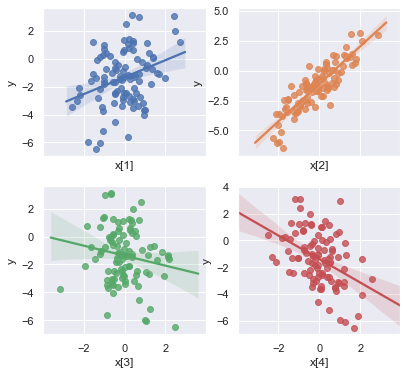

In [4]:
fig, axes = plt.subplots(int(np.ceil(D/2)), 2, sharex=True)
fig.set_size_inches(6.4, 6)
for i in range(D):
  t_ax = axes[int(i/2), i%2] #this axis
  sns.regplot(x[:,i], y[:,0], ax=t_ax)
  t_ax.set_ylabel('y')
  t_ax.set_xlabel('x[%d]'%(i+1))
plt.show()

In [5]:
def linear_regression(features):
  D = features.shape[1]      #number of dimensions
  coeffs = ed.Normal(        #normal prior on weights
      loc=tf.zeros([D,1]),
      scale=tf.ones([D,1]),
      name="coeffs")
  bias = ed.Normal(          #normal prior on bias
      loc=tf.zeros([1]), 
      scale=tf.ones([1]),
      name="bias") 
  noise_std = ed.HalfNormal( #half-normal prior on noise std
      scale=tf.ones([1]),
      name="noise_std")
  predictions = ed.Normal(   #normally-distributed noise
      loc=tf.matmul(features, coeffs)+bias,
      scale=noise_std,
      name="predictions")
  return predictions

In [6]:
log_joint = ed.make_log_joint_fn(linear_regression)

In [7]:
x.shape[1]

4

In [10]:
y

array([[-0.6938427 ],
       [ 0.11282504],
       [-2.7300315 ],
       [ 1.1586052 ],
       [-2.995339  ],
       [-3.207323  ],
       [ 3.06885   ],
       [-1.605787  ],
       [-2.4410148 ],
       [-1.1953031 ],
       [-1.3495519 ],
       [-2.8517418 ],
       [-2.7199059 ],
       [-0.42324364],
       [-2.5903296 ],
       [ 0.59417546],
       [-0.6443019 ],
       [-1.6767348 ],
       [-0.05240953],
       [-1.0674807 ],
       [-0.9930879 ],
       [-1.5796382 ],
       [-1.3369915 ],
       [-3.4179444 ],
       [ 1.3200494 ],
       [-3.0591002 ],
       [-0.7468442 ],
       [-0.22765619],
       [ 0.41047323],
       [-3.3931804 ],
       [-0.58682275],
       [-3.5279279 ],
       [-0.77503574],
       [-0.77669895],
       [ 0.62864685],
       [-2.0729184 ],
       [-1.8278824 ],
       [-0.47670835],
       [-2.0821939 ],
       [ 1.9820105 ],
       [-4.5611763 ],
       [-0.22488475],
       [-2.4409897 ],
       [-1.4873668 ],
       [ 1.2170299 ],
       [-1

In [18]:
def target_log_prob_fn(coeffs, bias, noise_std):
  return log_joint(
      features=x,
      coeffs=coeffs,
      bias=bias,
      noise_std=noise_std,
      predictions=y)

In [19]:
class Timer:
  def __enter__(self):
    self.t0 = time.time()
  def __exit__(self, *args):
    print('Elapsed time: %0.2fs' % (time.time()-self.t0))
    
with Timer():
  time.sleep(3.14)

Elapsed time: 3.14s


In [20]:
num_results = int(10e3) #number of hmc iterations
n_burnin = int(5e3)     #number of burn-in steps
step_size = 0.01
num_leapfrog_steps = 10

# Parameter sizes
coeffs_size = [D,1]
bias_size = [1]
noise_std_size = [1]

In [21]:
# HMC transition kernel
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=step_size,
    num_leapfrog_steps=num_leapfrog_steps)

# Define the chain states
states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=n_burnin,
    kernel=kernel,
    current_state=[
        tf.zeros(coeffs_size, name='init_coeffs'),
        tf.zeros(bias_size, name='init_bias'),
        tf.ones(noise_std_size, name='init_noise_std'),
    ])
coeffs, bias, noise_std = states

W0909 17:24:49.945754 4629382592 deprecation.py:323] From /Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [35]:
bias

<tf.Tensor 'mcmc_sample_chain/trace_scan/TensorArrayStack_1/TensorArrayGatherV3:0' shape=(10000, 1) dtype=float32>

In [37]:
type(states)

list

In [34]:
type(bias)

tensorflow.python.framework.ops.Tensor

In [22]:
with Timer(), tf.Session() as sess:
  [
      coeffs_,
      bias_,
      noise_std_,
      is_accepted_,
  ] = sess.run([
      coeffs,
      bias,
      noise_std,
      kernel_results.is_accepted,
  ])

# Samples after burn-in
coeffs_samples = coeffs_[n_burnin:,:,0]
bias_samples = 
noise_std_samples = noise_std_[n_burnin:]
accepted_samples = is_accepted_[n_burnin:]

Elapsed time: 72.82s


In [29]:
np.shape(bias_[n_burnin:])

(5000, 1)

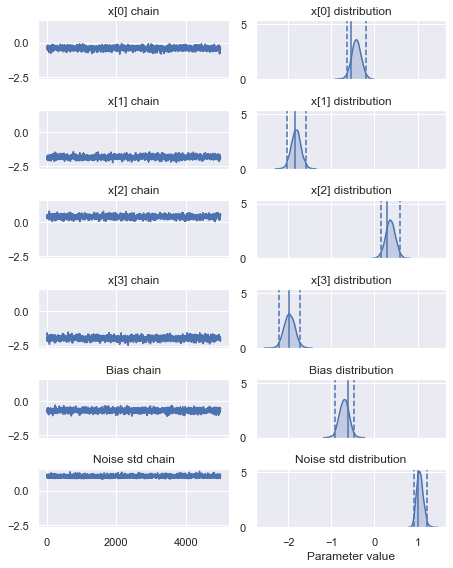

In [23]:
def chain_plot(data, title='', ax=None):
  '''Plot both chain and posterior distribution'''
  if ax is None:
    ax = plt.gca()
  ax.plot(data)
  ax.title.set_text(title+" chain")
  
def post_plot(data, title='', ax=None, true=None, prc=95):
  '''Plot the posterior distribution given MCMC samples'''
  if ax is None:
    ax = plt.gca()
  sns.kdeplot(data, ax=ax, shade=True)
  tprc = (100-prc)/2
  ax.axvline(x=np.percentile(data, tprc), linestyle='--')
  ax.axvline(x=np.percentile(data, 100-tprc), linestyle='--')
  ax.title.set_text(title+" distribution")
  if true is not None:
    ax.axvline(x=true)
    
def chain_post_plot(data, title='', ax=None, true=None):
  '''Plot a chain of MCMC samples'''
  chain_plot(data, title=title, ax=ax[0])
  post_plot(data, title=title, ax=ax[1], true=true)
  
# Plot chains and distributions for coefficients
fig, axes = plt.subplots(D+2, 2, sharex='col', sharey='col')
fig.set_size_inches(6.4, 8)
for i in range(D):
  chain_post_plot(coeffs_samples[:,i],
                  title="x[{}]".format(i),
                  ax=axes[i], true=w_true[i])
  
# Plot chains and distributions for bias
chain_post_plot(bias_samples[:,0],
                title="Bias",
                ax=axes[D], true=b_true)

# Plot chains and distributions for noise std dev
chain_post_plot(noise_std_samples[:,0],
                title="Noise std",
                ax=axes[D+1], true=noise_std_true)
  
axes[D+1][1].set_xlabel("Parameter value")
fig.tight_layout()
plt.show()

In [24]:
coeffs_samples

array([[-0.2592145 , -1.9457644 ,  0.47129264, -1.6549265 ],
       [-0.24810255, -1.8736495 ,  0.5172332 , -1.6311198 ],
       [-0.36513764, -1.9342242 ,  0.43197957, -1.5649248 ],
       ...,
       [-0.48071358, -1.8248835 ,  0.46428806, -2.0823011 ],
       [-0.42832834, -1.8146169 ,  0.5672054 , -2.127237  ],
       [-0.41407436, -1.8243965 ,  0.529285  , -1.9909205 ]],
      dtype=float32)